In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import kagglehub
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
from PIL import Image
import io
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download the dataset using kagglehub
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


**Model Architecture**

In [ ]:
# Function to create model architecture
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
    x = Dropout(0.1)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x

def build_multitask_unet(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder (Segmentation branch)
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    seg_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(d4)

    # Classification branch from bottleneck
    cls_branch = GlobalAveragePooling2D()(b)
    cls_branch = Dense(128, activation='relu')(cls_branch)
    cls_branch = Dropout(0.3)(cls_branch)
    cls_output = Dense(num_classes, activation='softmax', name='classification')(cls_branch)

    model = Model(inputs, outputs=[seg_output, cls_output])
    return model

**Pre-Prossecing Part**

In [ ]:
# Function to load and preprocess data
def load_data(path, img_size=(128, 128)):
    # Define category folders and their classes
    categories = {
        'normal': 0,
        'benign': 1,
        'malignant': 2
    }

    images = []
    masks = []
    labels = []


    dataset_path = os.path.join(path, "Dataset_BUSI_with_GT")

    for category in categories.keys():
        category_path = os.path.join(dataset_path, category)

        # Get all images in this category (they end with .png and don't have "_mask" in the name)
        img_paths = [f for f in glob(os.path.join(category_path, "*.png")) if "_mask" not in f]

        for img_path in img_paths:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue

            # Corresponding mask (same name but with _mask)
            mask_path = img_path.replace(".png", "_mask.png")
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            else:
                # If no mask exists (normal cases might not have masks), create empty mask
                mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

            # Resize
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            # Normalize image to [0,1]
            img = img / 255.0

            # Binarize mask (threshold at 128)
            mask = (mask > 128).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            # Append to collections
            images.append(img)
            masks.append(mask)
            labels.append(categories[category])

    # Convert to numpy arrays
    X = np.array(images)
    y_seg = np.array(masks)
    y_cls = to_categorical(np.array(labels), num_classes=len(categories))

    return X, y_seg, y_cls

In [ ]:
# Load the data
print("Loading and preprocessing data...")
X, y_seg, y_cls = load_data(path)
print(f"Loaded {len(X)} images")
print(f"Class distribution: {np.sum(y_cls, axis=0)}")

Loading and preprocessing data...
Loaded 780 images
Class distribution: [133. 437. 210.]


**Data Split**

In [ ]:
# Split the data
X_train, X_val, y_train_seg, y_val_seg, y_train_cls, y_val_cls = train_test_split(
    X, y_seg, y_cls, test_size=0.2, random_state=42, stratify=np.argmax(y_cls, axis=1)
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 624 samples
Validation set: 156 samples


**Model Build**

In [ ]:
# Build and compile the model
model = build_multitask_unet(input_shape=X_train.shape[1:])
model.summary()

alpha = 0.8 # Weight for segmentation loss
beta = 0.2 # Weight for classification loss

# Compile the model with weighted loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'segmentation': lambda y_true, y_pred: alpha * tf.keras.losses.binary_crossentropy(y_true, y_pred),
        'classification': lambda y_true, y_pred: beta * tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    },
    metrics={
        'segmentation': [MeanIoU(num_classes=2), 'accuracy'],
        'classification': ['accuracy']
    }
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,163,332 (118.88 MB)

 Trainable params: 31,163,332 (118.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint('breast_ultrasound_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

**Model train**

In [ ]:
# Train the model
history = model.fit(
    X_train,
    {'segmentation': y_train_seg, 'classification': y_train_cls},
    validation_data=(X_val, {'segmentation': y_val_seg, 'classification': y_val_cls}),
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - classification_accuracy: 0.5620 - classification_loss: 0.2171 - loss: 0.7098 - segmentation_accuracy: 0.7710 - segmentation_loss: 0.4927 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 860ms/step - classification_accuracy: 0.5618 - classification_loss: 0.2170 - loss: 0.7074 - segmentation_accuracy: 0.7738 - segmentation_loss: 0.4904 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.2114 - val_loss: 0.4619 - val_segmentation_accuracy: 0.9204 - val_segmentation_loss: 0.2503 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.5756 - classification_loss: 0.2042 - loss: 0.4494 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.2452 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - classification_accuracy: 0.5752 - classification_loss: 0.2041 - loss: 0.4488 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.2447 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.1966 - val_loss: 0.3901 - val_segmentation_accuracy: 0.9204 - val_segmentation_loss: 0.1935 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - classification_accuracy: 0.5756 - classification_loss: 0.1918 - loss: 0.3684 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.1766 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - classification_accuracy: 0.5752 - classification_loss: 0.1919 - loss: 0.3683 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.1765 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.1979 - val_loss: 0.3726 - val_segmentation_accuracy: 0.9204 - val_segmentation_loss: 0.1740 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - classification_accuracy: 0.5756 - classification_loss: 0.1900 - loss: 0.3551 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.1652 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - classification_accuracy: 0.5752 - classification_loss: 0.1900 - loss: 0.3551 - segmentation_accuracy: 0.9233 - segmentation_loss: 0.1651 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.1948 - val_loss: 0.3524 - val_segmentation_accuracy: 0.9228 - val_segmentation_loss: 0.1572 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - classification_accuracy: 0.5756 - classification_loss: 0.1878 - loss: 0.3420 - segmentation_accuracy: 0.9268 - segmentation_loss: 0.1543 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - classification_accuracy: 0.5752 - classification_loss: 0.1878 - loss: 0.3420 - segmentation_accuracy: 0.9268 - segmentation_loss: 0.1542 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.1949 - val_loss: 0.3489 - val_segmentation_accuracy: 0.9303 - val_segmentation_loss: 0.1534 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - classification_accuracy: 0.5756 - classification_loss: 0.1857 - loss: 0.3365 - segmentation_accuracy: 0.9293 - segmentation_loss: 0.1507 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - classification_accuracy: 0.5752 - classification_loss: 0.1858 - loss: 0.3364 - segmentation_accuracy: 0.9294 - segmentation_loss: 0.1506 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5577 - val_classification_loss: 0.1841 - val_loss: 0.3271 - val_segmentation_accuracy: 0.9328 - val_segmentation_loss: 0.1426 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - classification_accuracy: 0.5743 - classification_loss: 0.1818 - loss: 0.3288 - segmentation_accuracy: 0.9309 - segmentation_loss: 0.1469 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - classification_accuracy: 0.5738 - classification_loss: 0.1819 - loss: 0.3287 - segmentation_accuracy: 0.9310 - segmentation_loss: 0.1468 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5705 - val_classification_loss: 0.1780 - val_loss: 0.3146 - val_segmentation_accuracy: 0.9354 - val_segmentation_loss: 0.1362 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - classification_accuracy: 0.5935 - classification_loss: 0.1753 - loss: 0.3127 - segmentation_accuracy: 0.9362 - segmentation_loss: 0.1374 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - classification_accuracy: 0.5931 - classification_loss: 0.1753 - loss: 0.3126 - segmentation_accuracy: 0.9363 - segmentation_loss: 0.1373 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6154 - val_classification_loss: 0.1684 - val_loss: 0.2968 - val_segmentation_accuracy: 0.9381 - val_segmentation_loss: 0.1283 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - classification_accuracy: 0.6329 - classification_loss: 0.1680 - loss: 0.2975 - segmentation_accuracy: 0.9400 - segmentation_loss: 0.1295 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - classification_accuracy: 0.6327 - classification_loss: 0.1680 - loss: 0.2975 - segmentation_accuracy: 0.9400 - segmentation_loss: 0.1295 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.5769 - val_classification_loss: 0.1712 - val_loss: 0.2907 - val_segmentation_accuracy: 0.9436 - val_segmentation_loss: 0.1194 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - classification_accuracy: 0.6344 - classification_loss: 0.1651 - loss: 0.2876 - segmentation_accuracy: 0.9434 - segmentation_loss: 0.1225 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - classification_accuracy: 0.6345 - classification_loss: 0.1650 - loss: 0.2876 - segmentation_accuracy: 0.9434 - segmentation_loss: 0.1225 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6795 - val_classification_loss: 0.1584 - val_loss: 0.2805 - val_segmentation_accuracy: 0.9434 - val_segmentation_loss: 0.1221 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - classification_accuracy: 0.6607 - classification_loss: 0.1523 - loss: 0.2719 - segmentation_accuracy: 0.9443 - segmentation_loss: 0.1196 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - classification_accuracy: 0.6607 - classification_loss: 0.1522 - loss: 0.2717 - segmentation_accuracy: 0.9444 - segmentation_loss: 0.1195 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6346 - val_classification_loss: 0.1528 - val_loss: 0.2649 - val_segmentation_accuracy: 0.9464 - val_segmentation_loss: 0.1123 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - classification_accuracy: 0.6694 - classification_loss: 0.1438 - loss: 0.2570 - segmentation_accuracy: 0.9474 - segmentation_loss: 0.1132 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6154 - val_classification_loss: 0.1673 - val_loss: 0.2799 - val_segmentation_accuracy: 0.9465 - val_segmentation_loss: 0.1121 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 13/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - classification_accuracy: 0.6662 - classification_loss: 

39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - classification_accuracy: 0.6666 - classification_loss: 0.1460 - loss: 0.2566 - segmentation_accuracy: 0.9487 - segmentation_loss: 0.1106 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6603 - val_classification_loss: 0.1361 - val_loss: 0.2472 - val_segmentation_accuracy: 0.9489 - val_segmentation_loss: 0.1110 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 14/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - classification_accuracy: 0.7089 - classification_loss: 0.1238 - loss: 0.2383 - segmentation_accuracy: 0.9472 - segmentation_loss: 0.1144 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6859 - val_classification_loss: 0.1385 - val_loss: 0.2478 - val_segmentation_accuracy: 0.9479 - val_segmentation_loss: 0.1091 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 15/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - classification_accuracy: 0.7018 - classification_loss: 

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - classification_accuracy: 0.7022 - classification_loss: 0.1257 - loss: 0.2285 - segmentation_accuracy: 0.9517 - segmentation_loss: 0.1028 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6731 - val_classification_loss: 0.1335 - val_loss: 0.2458 - val_segmentation_accuracy: 0.9474 - val_segmentation_loss: 0.1116 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 16/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - classification_accuracy: 0.7499 - classification_loss: 0.1148 - loss: 0.2236 - segmentation_accuracy: 0.9500 - segmentation_loss: 0.1088 - segmentation_mean_io_u: 0.4616

39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 358ms/step - classification_accuracy: 0.7499 - classification_loss: 0.1149 - loss: 0.2235 - segmentation_accuracy: 0.9501 - segmentation_loss: 0.1086 - segmentation_mean_io_u: 0.4616 - val_classification_accuracy: 0.6987 - val_classification_loss: 0.1208 - val_loss: 0.2246 - val_segmentation_accuracy: 0.9514 - val_segmentation_loss: 0.1032 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 17/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - classification_accuracy: 0.7992 - classification_loss: 0.1025 - loss: 0.2006 - segmentation_accuracy: 0.9547 - segmentation_loss: 0.0981 - segmentation_mean_io_u: 0.4617

39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step - classification_accuracy: 0.7990 - classification_loss: 0.1026 - loss: 0.2007 - segmentation_accuracy: 0.9547 - segmentation_loss: 0.0981 - segmentation_mean_io_u: 0.4617 - val_classification_accuracy: 0.6859 - val_classification_loss: 0.1218 - val_loss: 0.2206 - val_segmentation_accuracy: 0.9557 - val_segmentation_loss: 0.0982 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 18/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - classification_accuracy: 0.7930 - classification_loss: 0.0937 - loss: 0.1844 - segmentation_accuracy: 0.9581 - segmentation_loss: 0.0907 - segmentation_mean_io_u: 0.4617

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - classification_accuracy: 0.7932 - classification_loss: 0.0937 - loss: 0.1844 - segmentation_accuracy: 0.9581 - segmentation_loss: 0.0907 - segmentation_mean_io_u: 0.4617 - val_classification_accuracy: 0.7179 - val_classification_loss: 0.1178 - val_loss: 0.2135 - val_segmentation_accuracy: 0.9566 - val_segmentation_loss: 0.0948 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 19/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - classification_accuracy: 0.8190 - classification_loss: 0.0879 - loss: 0.1774 - segmentation_accuracy: 0.9592 - segmentation_loss: 0.0894 - segmentation_mean_io_u: 0.4619

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - classification_accuracy: 0.8189 - classification_loss: 0.0880 - loss: 0.1774 - segmentation_accuracy: 0.9592 - segmentation_loss: 0.0894 - segmentation_mean_io_u: 0.4619 - val_classification_accuracy: 0.7244 - val_classification_loss: 0.1136 - val_loss: 0.2094 - val_segmentation_accuracy: 0.9578 - val_segmentation_loss: 0.0950 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 20/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - classification_accuracy: 0.8500 - classification_loss: 0.0803 - loss: 0.1620 - segmentation_accuracy: 0.9620 - segmentation_loss: 0.0817 - segmentation_mean_io_u: 0.4622 - val_classification_accuracy: 0.7179 - val_classification_loss: 0.1255 - val_loss: 0.2149 - val_segmentation_accuracy: 0.9599 - val_segmentation_loss: 0.0884 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-04
Epoch 21/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - classification_accuracy: 0.8570 - classification_loss:

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - classification_accuracy: 0.9025 - classification_loss: 0.0553 - loss: 0.1214 - segmentation_accuracy: 0.9678 - segmentation_loss: 0.0661 - segmentation_mean_io_u: 0.4630 - val_classification_accuracy: 0.7821 - val_classification_loss: 0.1043 - val_loss: 0.1911 - val_segmentation_accuracy: 0.9631 - val_segmentation_loss: 0.0851 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-05
Epoch 26/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - classification_accuracy: 0.9189 - classification_loss: 0.0455 - loss: 0.1070 - segmentation_accuracy: 0.9693 - segmentation_loss: 0.0615 - segmentation_mean_io_u: 0.4622 - val_classification_accuracy: 0.7949 - val_classification_loss: 0.1058 - val_loss: 0.1946 - val_segmentation_accuracy: 0.9638 - val_segmentation_loss: 0.0869 - val_segmentation_mean_io_u: 0.4602 - learning_rate: 1.0000e-05
Epoch 27/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - classification_accuracy: 0.9105 - classification_loss:

**Visual Representation**

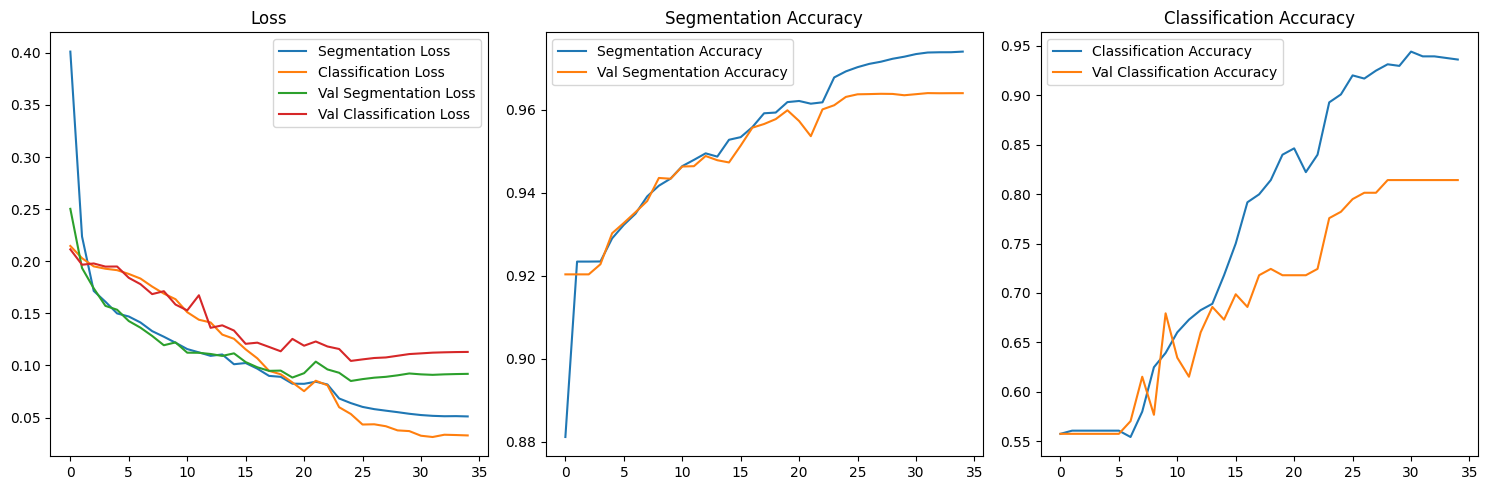

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['segmentation_loss'], label='Segmentation Loss')
    plt.plot(history.history['classification_loss'], label='Classification Loss')
    plt.plot(history.history['val_segmentation_loss'], label='Val Segmentation Loss')
    plt.plot(history.history['val_classification_loss'], label='Val Classification Loss')
    plt.title('Loss')
    plt.legend()

    # Plot segmentation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['segmentation_accuracy'], label='Segmentation Accuracy')
    plt.plot(history.history['val_segmentation_accuracy'], label='Val Segmentation Accuracy')
    plt.title('Segmentation Accuracy')
    plt.legend()

    # Plot classification accuracy
    plt.subplot(1, 3, 3)
    plt.plot(history.history['classification_accuracy'], label='Classification Accuracy')
    plt.plot(history.history['val_classification_accuracy'], label='Val Classification Accuracy')
    plt.title('Classification Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_history(history)


Generating visualizations with binary masks...
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step


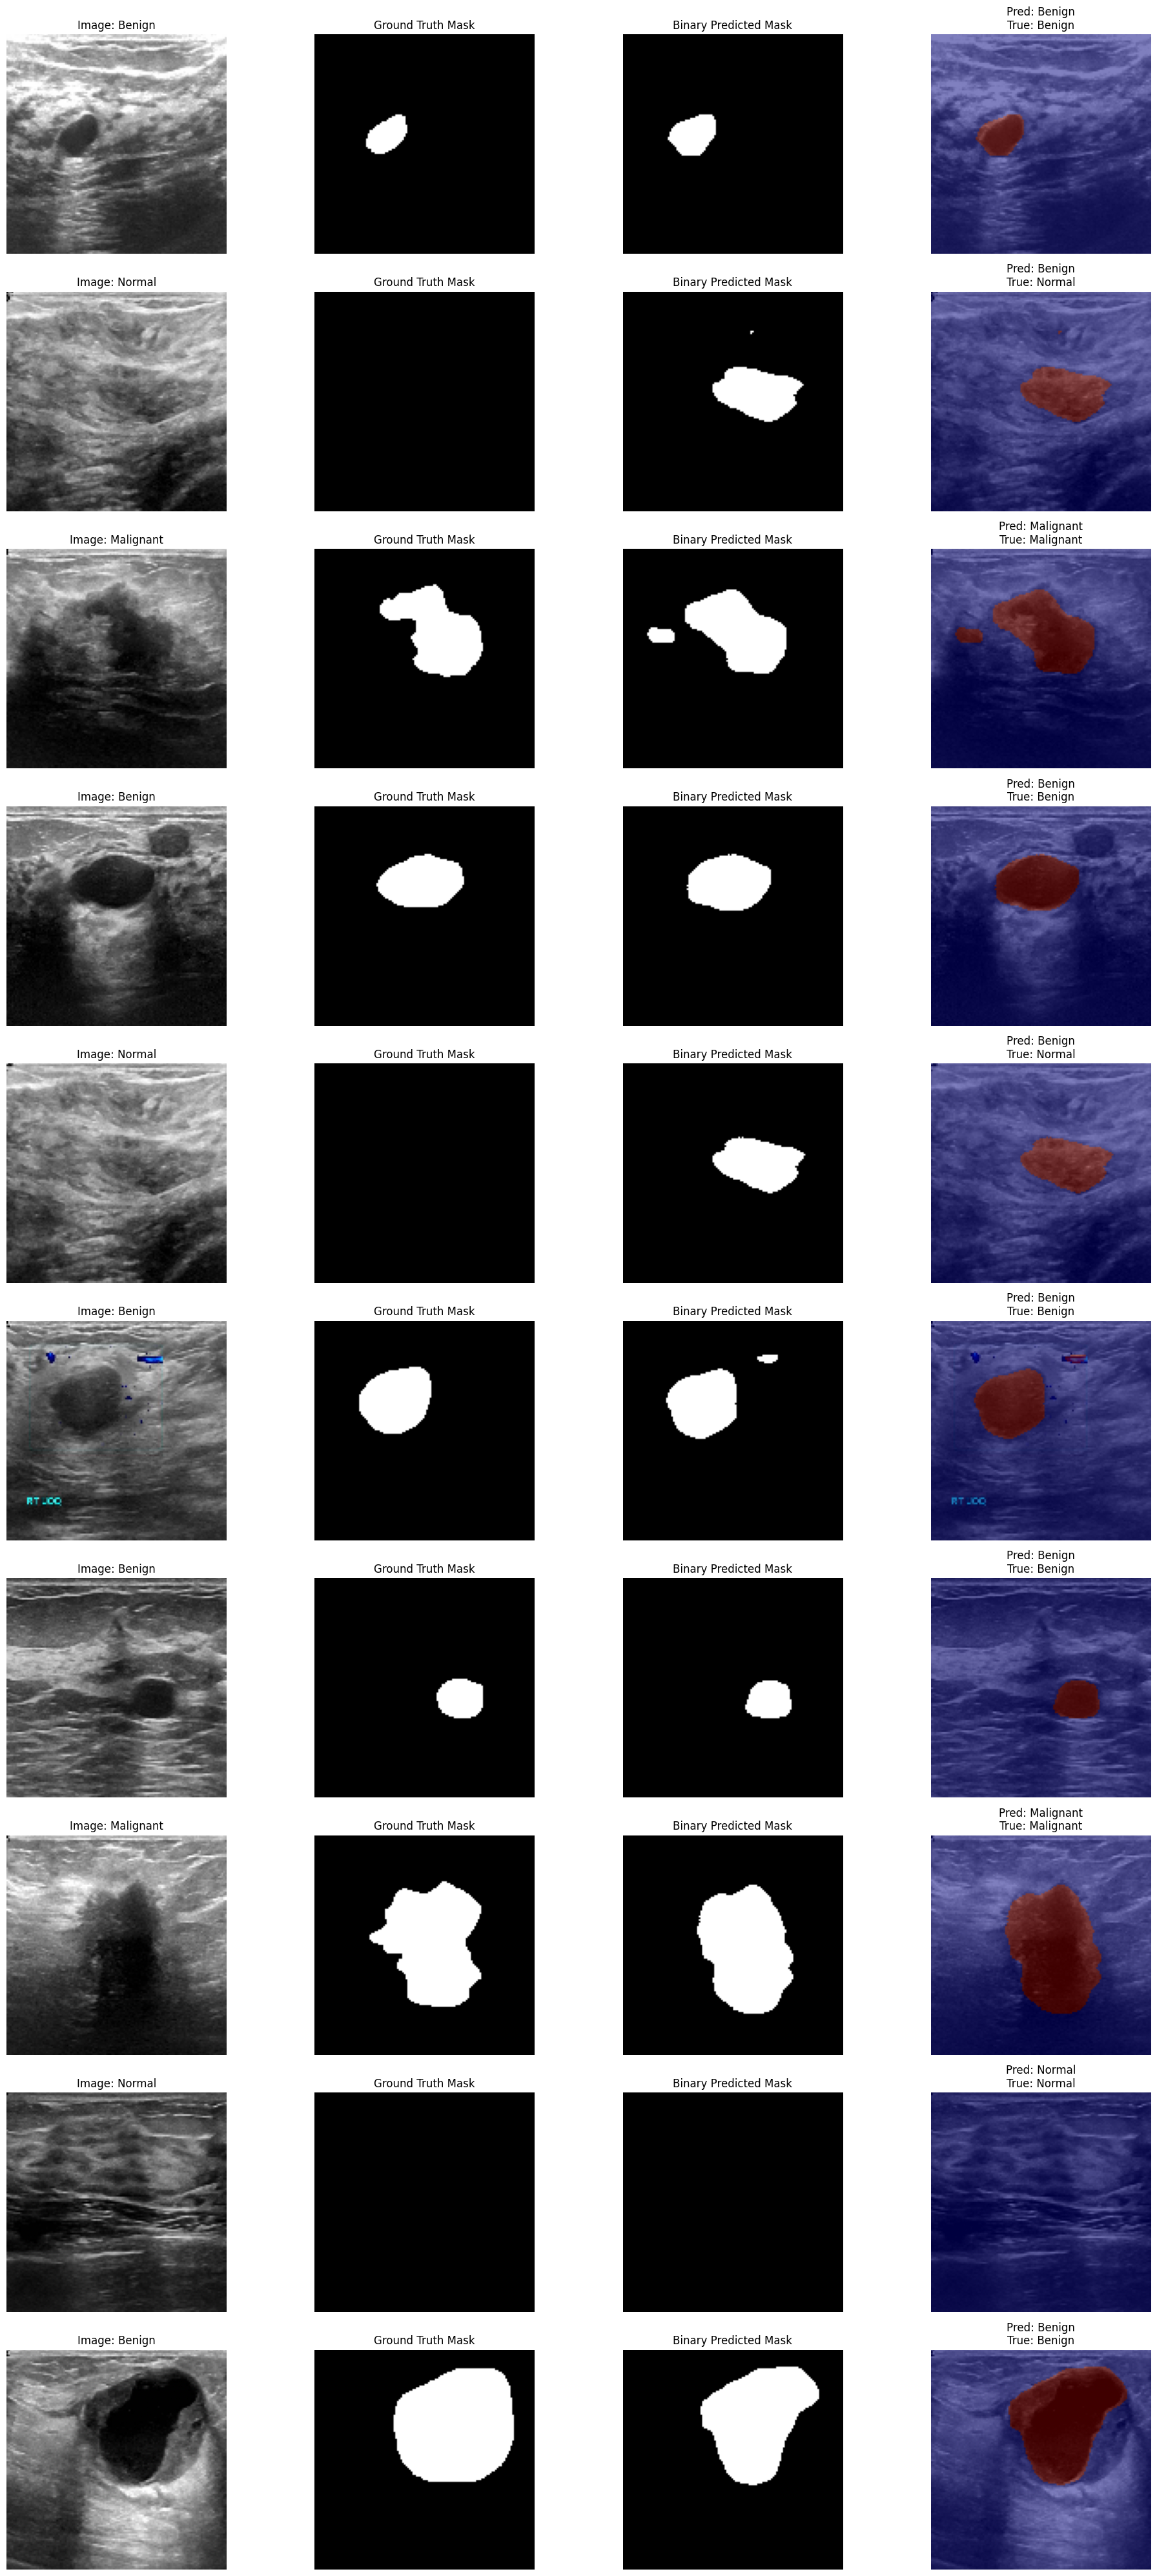

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize predictions with binary predicted masks
def visualize_predictions(model, X, y_seg, y_cls, num_samples=10):
    # Get predictions
    seg_pred, cls_pred = model.predict(X)

    # Threshold the predicted masks to make them binary
    binary_seg_pred = (seg_pred > 0.5).astype(np.uint8)

    # Class names
    class_names = ['Normal', 'Benign', 'Malignant']

    plt.figure(figsize=(20, 4*num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(X[i])
        plt.title(f'Image: {class_names[np.argmax(y_cls[i])]}')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(y_seg[i, :, :, 0], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Binary Predicted mask
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(binary_seg_pred[i, :, :, 0], cmap='gray')
        plt.title('Binary Predicted Mask')
        plt.axis('off')

        # Comparison (overlay original image with predicted binary mask)
        plt.subplot(num_samples, 4, i*4+4)
        plt.imshow(X[i])
        plt.imshow(binary_seg_pred[i, :, :, 0], alpha=0.5, cmap='jet')
        pred_class = np.argmax(cls_pred[i])
        true_class = np.argmax(y_cls[i])
        plt.title(f'Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('predictions_binary.png')
    plt.show()

print("Generating visualizations with binary masks...")
visualize_predictions(model, X_val, y_val_seg, y_val_cls)


In [ ]:
# Predict on validation data
y_pred_seg, y_pred_cls = model.predict(X_val)

# Threshold segmentation predictions
y_pred_seg_bin = (y_pred_seg > 0.5).astype(np.uint8)
y_true_seg_bin = (y_val_seg > 0.5).astype(np.uint8)

# SEGMENTATION METRICS

# 1. Mean IoU
miou = MeanIoU(num_classes=2)
miou.update_state(y_true_seg_bin, y_pred_seg_bin)
mean_iou = miou.result().numpy()

# 2. Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice = dice_coef(y_true_seg_bin, y_pred_seg_bin)

# 3. Pixel Accuracy
pixel_acc = np.mean(y_true_seg_bin == y_pred_seg_bin)


# CLASSIFICATION METRICS

y_true_cls = np.argmax(y_val_cls, axis=1)
y_pred_cls_labels = np.argmax(y_pred_cls, axis=1)

cls_acc = accuracy_score(y_true_cls, y_pred_cls_labels)
cls_precision = precision_score(y_true_cls, y_pred_cls_labels, average='macro', zero_division=0)
cls_recall = recall_score(y_true_cls, y_pred_cls_labels, average='macro', zero_division=0)
cls_f1 = f1_score(y_true_cls, y_pred_cls_labels, average='macro', zero_division=0)

# PRINT RESULTS
print("\n--- SEGMENTATION METRICS ---")
print(f"Mean IoU:        {mean_iou:.4f}")
print(f"Dice Coefficient:{dice:.4f}")
print(f"Pixel Accuracy:  {pixel_acc:.4f}")

print("\n--- CLASSIFICATION METRICS ---")
print(f"Accuracy:        {cls_acc:.4f}")
print(f"Precision:       {cls_precision:.4f}")
print(f"Recall:          {cls_recall:.4f}")
print(f"F1-Score:        {cls_f1:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step

--- SEGMENTATION METRICS ---
Mean IoU:        0.7708
Dice Coefficient:0.7346
Pixel Accuracy:  0.9631

--- CLASSIFICATION METRICS ---
Accuracy:        0.7821
Precision:       0.7648
Recall:          0.7530
F1-Score:        0.7545


<Figure size 600x600 with 0 Axes>

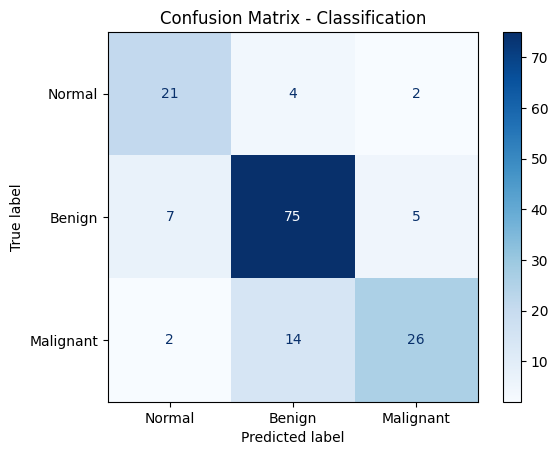

In [ ]:
# CONFUSION MATRIX

# Compute confusion matrix
cm = confusion_matrix(y_true_cls, y_pred_cls_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Benign', 'Malignant'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Classification")
plt.grid(False)
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
model.save('breast_ultrasound_multitask_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Helper: Preprocess uploaded image
def preprocess_image(image, target_size=(128, 128)):
    image = image.convert('RGB')
    image = image.resize(target_size)
    img_array = img_to_array(image) / 255.0
    return np.expand_dims(img_array, axis=0)

# Helper: Overlay mask on image
def overlay_mask(image, mask, alpha=0.5):
    image = np.array(image.resize(mask.shape[::-1])) / 255.0
    overlay = image.copy()
    overlay[mask > 0.5] = [1, 0, 0]
    return (alpha * image + (1 - alpha) * overlay)

# Upload and predict
from tensorflow.keras.models import load_model
model = load_model('/content/breast_ultrasound_model.h5')
uploaded = files.upload()
for filename in uploaded.keys():
    # Load and preprocess
    img_pil = Image.open(io.BytesIO(uploaded[filename]))
    input_tensor = preprocess_image(img_pil)

    # Predict
    prediction = model.predict(input_tensor)[0]
    if prediction.shape[-1] > 1:
        prediction_mask = np.argmax(prediction, axis=-1)
    else:
        prediction_mask = prediction.squeeze()

    # Threshold if binary
    prediction_mask = (prediction_mask > 0.5).astype(np.uint8)

    # Overlay
    overlay = overlay_mask(img_pil, prediction_mask)

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_pil)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
